# 4. 300 Neuron Model with PointNet (and PopNet?)

In the last tutorial we build a toy model of the Mouse Visual Cortex system with 300 biophysically detailed neurons, that we ran with BioNet (eg NEURON). This time we will build/convert a similar model but instead using PointNet with point-neuron based models. Particularly we will used the Generalized Integrate-and-Fire (GLIF) models created at the Allen Institute and for which we can find optimized models in the Allen Cell-Types Database.

As we will see the process for building and simulating point-neuron models are similar to biophysically detailed neurons, with the appropiate adjustments.

In [1]:
import os
import shutil
from distutils.dir_util import copy_tree
import numpy as np
import pandas as pd
import nest

from bmtk.builder.networks import NetworkBuilder
from bmtk.simulator import pointnet
from bmtk.analyzer.compartment import plot_traces
from bmtk.analyzer.spike_trains import plot_raster

[INFO] [2022.6.28 10:40:58 /home/conda/feedstock_root/build_artifacts/nest-simulator_1629288234048/work/nestkernel/rng_manager.cpp:217 @ Network::create_rngs_] : Creating default RNGs
[INFO] [2022.6.28 10:40:58 /home/conda/feedstock_root/build_artifacts/nest-simulator_1629288234048/work/nestkernel/rng_manager.cpp:260 @ Network::create_grng_] : Creating new default global RNG

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: nest-2.20.1
 Built: Aug 18 2021 12:09:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Downloading the Models

As before we will first want to find appropiate models using the [Allen Cell-Types Database Feature Search](https://celltypes.brain-map.org/data). We choose 3 different spiny exciatory models (identified by expressing Scnn1a, Rorb, and Nr5a1) and one inhibitory model (identified by expressing PValb) for "Mouse" in the Location "VISp", "L4".

This time we also want to make sure we want to check the box "Has GLIF Model".

There are actually five different variations of the GLIF model, we are primarily interested in the "type 3: LIF-ASC" models. Choose that from the "select Neuronal Model" dropdown, which will bring up the option to "Download model" a the bottom of the page:

![](../images/cell_types_db_glif_selection_highlighted.png)

The main file we are looking for is called _neuron_config.json_, which like _fit_parameters.json_ for perisomatic models contains the **dynamics_params**. Rename _neuron_config.json_ to something more informative, then copy the file _components/point_neuron_models/_ directory.

As before we already did this - but feel free to choose your own models.



## Creating the Model

There are two ways we can build a 300 point-neuron version of the L4 model we created in the last chapter.

1. <ins>Copy the model and adjust parameters manually</ins> - If you already built the model you can just copy the files into the _network/_ directory. This way the cell-positions and connectivity matrix will be exactly the same as our biophysical network (due to calls to ```np.random``` each time we build the network it is a little different). However a number of properties in the _node_types.csv_ and _edge_types.csv_ will need to be adjusted so that BMTK can work with our GLIF models. We can do it in a text editor or even programatically using pandas.


2. <ins>Rebuild the model from scratch</ins> - This will involve using the same ```add_nodes()``` and ```add_edges()``` method we used in the previous chapter. Some properties, like **model_type**, **dynamics_params**, **syn_weight** will need to be adjusted to deal wit the fact that we are using completely different models. Other properties, **morphology** and **afferent_section_id**, **rotation_angle_\*** can be removed completely as they won't apply to point-neurons.

### 1. Copying an existing model

We can copy the previous chapter's network files in the command line

```bash
$ mkdir -p network_copied
$ cp ../Ch3_multicells/network/* network_copied
```

Then we make the appropiate changes the _l4_nodes_types.csv_, which we can do in a text editor or using pandas

In [2]:
import os
from distutils.dir_util import copy_tree

os.makedirs('network_copied', exist_ok=True)
copy_tree('../Ch3_multicells/network', 'network_copied')

['network_copied/l4_l4_edge_types.csv',
 'network_copied/l4_l4_edges.h5',
 'network_copied/l4_lifs_edge_types.csv',
 'network_copied/l4_lifs_edges.h5',
 'network_copied/l4_node_types.csv',
 'network_copied/l4_nodes.h5',
 'network_copied/lgn_l4_edge_types.csv',
 'network_copied/lgn_l4_edges.h5',
 'network_copied/lgn_node_types.csv',
 'network_copied/lgn_nodes.h5',
 'network_copied/lifs_l4_edge_types.csv',
 'network_copied/lifs_l4_edges.h5',
 'network_copied/lifs_lifs_edge_types.csv',
 'network_copied/lifs_lifs_edges.h5',
 'network_copied/lifs_node_types.csv',
 'network_copied/lifs_nodes.h5']

Then we make the appropiate changes the l4_nodes_types.csv, which we can do in a text editor or using pandas

In [3]:
import pandas as pd

node_types_df = pd.read_csv('network_copied/l4_node_types.csv', sep=' ')

# remove unnessecarry columns
node_types_df = node_types_df.drop(columns=['model_processing', 'rotation_angle_zaxis'])

# change model properties directive
node_types_df['model_type'] = 'point_neuron'
node_types_df['model_template'] = 'nest:glif_lif_asc_psc'
node_types_df = node_types_df.replace({
    'Scnn1a_485510712_params.json': 'Scnn1a_593618144_glif_lif_asc.json',
    'Rorb_486509958_params.json': 'Rorb_480124551_glif_lif_asc.json',
    'Nr5a1_485507735_params.json': 'Nr5a1_318808427_glif_lif_asc.json',
    'Pvalb_473862421_params.json': 'Pvalb_487667205_glif_lif_asc.json'
})

# save 
node_types_df.to_csv('network_copied/l4_node_types.csv', sep=' ', index=False)


node_types_df

,node_type_id,model_template,dynamics_params,morphology,model_type,model_name,ei_type
0,100,nest:glif_lif_asc_psc,Scnn1a_593618144_glif_lif_asc.json,Scnn1a_485510712_morphology.swc,point_neuron,Scnn1a,e
1,101,nest:glif_lif_asc_psc,Rorb_480124551_glif_lif_asc.json,Rorb_486509958_morphology.swc,point_neuron,Rorb,e
2,102,nest:glif_lif_asc_psc,Nr5a1_318808427_glif_lif_asc.json,Nr5a1_485507735_morphology.swc,point_neuron,Nr5a1,e
3,103,nest:glif_lif_asc_psc,Pvalb_487667205_glif_lif_asc.json,Pvalb_473862421_morphology.swc,point_neuron,PValb,i


In [4]:
for et_path in ['network_copied/l4_l4_edge_types.csv', 'network_copied/lgn_l4_edge_types.csv']:
    edge_types_df = pd.read_csv(et_path, sep=' ')
    edge_types_df['model_template'] = 'static_synapse'
    edge_types_df = edge_types_df.replace(
        {'dynamics_params': 'AMPA|GABA'}, 
        {'dynamics_params': 'static'}, 
        regex=True
    )

    # Make it easier to change syn_weight by hand, move 'syn_weight' to end 
    syn_weight = edge_types_df.pop('syn_weight')
    edge_types_df['syn_weight'] = '<TBD>'

    edge_types_df.to_csv(et_path, sep=' ', index=False)

Finally we will want to open our _edge_types.csv_ and modify the **syn_weight** column values. Readjusting synaptic weights when moving from biophysical models to point neuron models, or even between two different model types of the same level, can be very difficult. Although there are some tools in development which may help with parameter optimization of synaptic weights, like [nested](https://github.com/neurosutras/nested), the process often requires a lot of trial-and-error.

We will often have to run multiple iterations of different types of simulations on individual neurons and the network and constantly update **syn_weight** until we can get expected firing rates:

![](../images/update_syn_weights.png)

### 2. Rebuilding the model

The following is a modification of the previous build script for our 300 L4 + 100 LGN network, but designed to run in PointNet. Some things to note:

* The rules for generating coordinates, creating connections between each cell (using tuning angle/distance) is the same as with the biophysical model.


* We know longer are using the ```add_properties()``` method to find the sectional placement of the afferent synapse. We still need to know number of synapses between a source/target pair of cells, but since the cells are just geometric "points" there is only one place we can put the synpases. 


* Our **model_type** will always be "point_neuron". For the nodes' **model_template** we can choose from any number of the [available NEST cell models](https://nest-simulator.readthedocs.io/en/v3.2/models/index.html) or even build our own, although we will strictly be using the "glif_psc" model.


* For our edges **model_template** we can also choose from one of the available [built-in synaptic models](https://nest-simulator.readthedocs.io/en/v3.2/models/index_synapse.html) or build our own. For simplicity we will be sticking with the standard "static_synapse" with the synaptic properties for each model saved in _components/synpatic_models/_ directory.


#### Helper functions

In [5]:
import numpy as np


def get_coords_column(N, radius_min=0.0, radius_max=400.0):
    phi = 2.0 * np.pi * np.random.random([N])
    r = np.sqrt((radius_min**2 - radius_max**2) * np.random.random([N]) + radius_max**2)
    x = r * np.cos(phi)
    y = np.random.uniform(400.0, 500.0, size=N)
    z = r * np.sin(phi)
    return x, y, z


def get_coords_plane(ncells, size_x=240.0, size_y=120.0):
    xs = np.random.uniform(0.0, size_x, ncells)
    ys = np.random.uniform(0.0, size_y, ncells)
    return xs, ys


def exc_exc_rule(source, target, max_syns):
    """Connect rule for exc-->exc neurons, should return an integer 0 or greater. The number of 
    connections will be weighted according to the difference between source and target cells' 
    tuning_angle property"""
    if source['node_id'] == target['node_id']:
        # prevent a cell from synapsing with itself
        return 0
    
    # calculate the distance between tuning angles and use it to choose
    # number of connections using a binomial distribution.
    src_tuning = source['tuning_angle']
    trg_tuning = target['tuning_angle']
    tuning_dist = np.abs((src_tuning - trg_tuning + 180) % 360 - 180)
    probs = 1.0 - (np.max((tuning_dist, 10.0)) / 180.0)
    return np.random.binomial(n=max_syns, p=probs)


def others_conn_rule(source, target, max_syns, max_distance=300.0, sigma=60.0):
    """Connection rule for exc-->inh, inh-->exc, or inh-->inh connections. The number of connections
    will be based on the euclidian distance between source and target cell.
    """
    if source['node_id'] == target['node_id']:
        return 0
    
    dist = np.sqrt((source['x'] - target['x'])**2 + (source['z'] - target['z'])**2)
    if dist > max_distance:
        return 0
    
    prob = np.exp(-(dist/sigma)**2)
    return np.random.binomial(n=max_syns, p=prob)

#### Building the recurrent (l4 --> l4) network

In [6]:
from bmtk.builder.networks import NetworkBuilder


l4 = NetworkBuilder('l4')

# Add nodes
x, y, z = get_coords_column(80)
l4.add_nodes(
    N=80,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Scnn1a_515806250_glif_lif_asc.json',   
    x=x, y=y, z=z,
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
    model_name='Scnn1a',
    ei_type='e'
)


x, y, z = get_coords_column(80)
l4.add_nodes(
    N=80,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Rorb_512332555_glif_lif_asc.json',
    x=x, y=y, z=z,   
    model_name='Rorb', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
)

x, y, z = get_coords_column(80)
l4.add_nodes(
    N=80,
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Nr5a1_587862586_glif_lif_asc.json',   
    x=x, y=y, z=z,    
    model_name='Nr5a1', 
    ei_type='e',
    tuning_angle=np.linspace(start=0.0, stop=360.0, num=80, endpoint=False),
)

x, y, z = get_coords_column(60)
l4.add_nodes(
    N=60,   
    model_type='point_neuron',
    model_template='nest:glif_lif_asc_psc',
    dynamics_params='Pvalb_574058595_glif_lif_asc.json',
    x=x, y=y, z=z, 
    model_name='PValb',
    ei_type='i',
)


# Add recurrent edges
l4.add_edges(
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='e'),    
    connection_rule=exc_exc_rule,
    connection_params={'max_syns': 15},
    syn_weight=1.0,
    delay=2.0,
    dynamics_params='static_ExcToExc.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='e'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 12},
    syn_weight=7.5,
    delay=2.0,
    dynamics_params='static_ExcToInh.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='e'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 14},
    syn_weight=-10.5,
    delay=2.0,
    dynamics_params='static_InhToExc.json',
    model_template='static_synapse',
)

l4.add_edges(
    source=l4.nodes(ei_type='i'),
    target=l4.nodes(ei_type='i'),
    connection_rule=others_conn_rule,
    connection_params={'max_syns': 14},
    syn_weight=-2.0,
    delay=2.0,
    dynamics_params='static_InhToInh.json',
    model_template='static_synapse',
)


In [7]:
l4.build()
l4.save(output_dir='network')

#### Building feedforward  (lgn -- l4) inputs

Now we can build our network of "virutal" LGN cells and connect them to the L4 network

In [8]:
def connect_lgn_cells(source, targets, max_targets, min_syns=1, max_syns=15, lgn_size=(240, 120),
                      l4_radius=400.0, ellipse=(100.0, 500.0)):
    # map the lgn cells from the plane to the circle
    x, y = source['x'], source['y']
    x = x / lgn_size[0] - 0.5
    y = y / lgn_size[1] - 0.5
    src_x = x * np.sqrt(1.0 - (y**2/2.0)) * l4_radius
    src_y = y * np.sqrt(1.0 - (x**2/2.0)) * l4_radius

    # Find (the indices) of all the target cells that are within the given ellipse, if there are more than max_targets
    # then randomly choose them
    a, b = ellipse[0]**2, ellipse[1]**2
    dists = [(src_x-t['x'])**2/a + (src_y-t['y'])**2/b for t in targets]
    valid_targets = np.argwhere(np.array(dists) <= 1.0).flatten()
    if len(valid_targets) > max_targets:
        valid_targets = np.random.choice(valid_targets, size=max_targets, replace=False)

    # create an array of all synapse count. Most targets with have 0 connection, except for the "valid_targets" which
    # will have between [min_syns, max_syns] number of connections.
    nsyns_arr = np.zeros(len(targets), dtype=np.int)
    for idx in valid_targets:
        nsyns_arr[idx] = np.random.randint(min_syns, max_syns)

    return nsyns_arr

In [9]:
lgn = NetworkBuilder('lgn')

# Build Nodes
x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tON_TF8',
    dynamics_params='tON_TF8.json',
    ei_type='e'
)

x, y = get_coords_plane(50)
lgn.add_nodes(
    N=50,
    x=x,
    y=y,
    model_type='virtual',
    model_template='lgnmodel:tOFF_TF8',
    dynamics_params='tOFF_TF8.json',
    ei_type='e'
)

# Build Edges
lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='e'),
    connection_rule = connect_lgn_cells,
    connection_params = {'max_targets': 6},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToExc.json',
    delay=2.0,
    syn_weight=11.0
)

lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(ei_type='i'),
    connection_rule=connect_lgn_cells,
    connection_params={'max_targets': 12, 'ellipse': (400.0, 400.0)},
    iterator='one_to_all',
    model_template='static_synapse',
    dynamics_params='static_ExcToInh.json',
    delay=2.0,
    syn_weight=13.0
)


In [10]:
lgn.build()
lgn.save(output_dir='network')

/tmp/ipykernel_25430/5825497.py:20: DeprecationWarning:`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


__[SUGGESTION: Visualize in VND]__

### Inputs for LGN

As before we need to provide inputs for our LGN "virtual" cells. We could use the ```bmtk.utils.reports.spike_trains.PoissonSpikeGenerator``` object as was done before. But since the spike-files are the same for BioNet and PointNet we can just copy the existing lgn-spikes:


In [11]:
import os
import shutil

os.makedirs('inputs', exist_ok=True)
shutil.copy('../Ch3_multicells/inputs/lgn_spikes.h5', 'inputs')

'inputs/lgn_spikes.h5'

### Setting up the environment

As before we need to initialize the simulation directory, including configuration files, python run scripts, and the model file components. We've already set this up for you. But if running a PointNet simulation from scratch the following can help using the sim_setup helper functions - either through the command line

```bash
$ python -m bmtk.utils.sim_setup          \
     --config-file config.simulation.json \
     --network network                    \
     --tstop 5000.0                       \      
     --dt 0.1                           \
     --report_vars=['V_m']                 \
     pointnet .
```

or through python:

```python
from bmtk.utils.sim_setup import build_env_pointnet

build_env_pointnet(
    base_dir='.',      
    network_dir='network',
    tstop=5000.0, 
    dt=0.1,
    report_vars=['V_m'],
    spikes_inputs=[('lgn', 'inputs/lgn_spikes.h5')],
)
```

### Running the Simulation

We can run our GLIF version of the L4 network either through the command line:

```bash
$ python run_pointnet.py config.simulation.json
```

We can use MPI to run the simulation on multiple cores:
```bash
$ mpirun -np N python run_pointnet.py config.simulation.json
```

or to run it in the notebook:

In [12]:
from bmtk.simulator import pointnet


configure = pointnet.Config.from_json('config.simulation.json')
configure.build_env()

network = pointnet.PointNetwork.from_config(configure)
sim = pointnet.PointSimulator.from_config(configure, network)
sim.run()

2022-06-28 10:41:38,456 [INFO] Created log file
2022-06-28 10:41:38,481 [INFO] Batch processing nodes for l4/0.
2022-06-28 10:41:38,482 [INFO] Batch processing nodes for l4/1.
2022-06-28 10:41:38,504 [INFO] Batch processing nodes for lgn/0.
2022-06-28 10:41:38,536 [INFO] Setting up output directory
2022-06-28 10:41:38,537 [INFO] Building cells.
2022-06-28 10:41:38,547 [INFO] Building recurrent connections
2022-06-28 10:41:38,597 [INFO] Build virtual cell stimulations for lgn_spikes
2022-06-28 10:41:38,693 [INFO] Network created.
2022-06-28 10:41:38,824 [INFO] Starting Simulation
2022-06-28 10:41:50,372 [INFO] Simulation finished, finalizing results.
2022-06-28 10:41:52,563 [INFO] Done.


/local1/workspace/bmtk/bmtk/analyzer/spike_trains.py:120: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


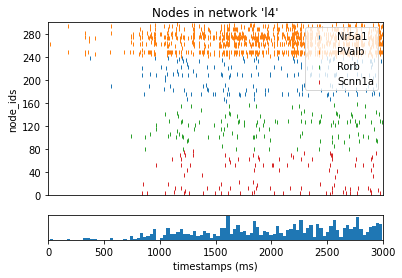

In [13]:
from bmtk.analyzer.spike_trains import plot_raster

_ = plot_raster(config_file='config.simulation.json', group_by='model_name', show=False)

/local1/workspace/bmtk/bmtk/analyzer/compartment.py:148: FutureWarning:The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


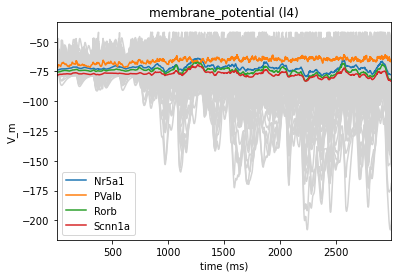

In [14]:
from bmtk.analyzer.compartment import plot_traces


_ = plot_traces(config_file='config.simulation.json', report_name='membrane_potential', group_by='model_name')

__[SUGGESTION: Plot Activity in VND]__

## [OPTIONAL] GLIF Models Deep Dive

__[SUGGESTION: It might be worth going over the GLIF models and their options?]__

## (Optional) PopNet

We've already built a version of our L4 model using multi-compartment biophysically detailed cells (BioNet) and point-neuron GLIF-based models (PointNet). BMTK includes a third simulator engine called PopNet which can be used to simulate population level firing rates using the DiPDE tool.

As before we have two options for building our GLIF Model
1. Build from scratch using BMTK's NetworkBuilder
2. Copy an existing biophysical/point model and modify the node-types and edge type params


### Building PopNet version of the L4 Model
Some things to take note:
* Populations don't have individual cells so essentially we need **N**=1, which is the same as using the default option.
* for **model_type** we want to use option 'population'
* Unlike with the Biophysical and GLIF model, there are no optimized DiPDE/PopNet models in the Allen-Cell Types database. Instead we need to build the **dynamics_params** parameter files from scratch (we'll briefly explain the options available)
* There are only two type **model_templates** for DiPDE/PopNet - "Internal" and "External" (equivelent to virtual cells). 


In [15]:
from bmtk.builder import NetworkBuilder


# Create and Build the L4 model
l4 = NetworkBuilder('l4')
l4.add_nodes(
    model_name='Scnn1a',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Scnn1a_pop_model.json'
)

l4.add_nodes(
    model_name='Rorb',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Rorb_pop_model.json'
)

l4.add_nodes(
    model_name='Nr5a1',
    ei_type='e',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Nr5a1_pop_model.json'
)

l4.add_nodes(
    pop_name='Pvalb',
    ei_type='i',
    model_type='population',
    model_template='dipde:Internal',
    dynamics_params='Pvalb_pop_model.json'
)


# Recurrently connect internal populations
def exc_exc_conns(source, target):
    if source['node_id'] == target['node_id']:
        return 0
    else:
        return 2


l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'e'},
    syn_weight=0.01,
    connection_rule=exc_exc_conns,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'

)

l4.add_edges(
    source={'ei_type': 'e'}, target={'ei_type': 'i'},
    syn_weight=0.005,
    nsyns=20,
    delay=0.002,
    dynamics_params='dipde_ExcToInh.json'
)

l4.add_edges(
    source={'ei_type': 'i'}, target={'ei_type': 'e'},
    syn_weight=-0.002,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_InhToExc.json'
)

l4.build()
l4.save(output_dir='network_popnet')

Now for our LGN cells

In [16]:
lgn = NetworkBuilder('lgn')
lgn.add_nodes(
    pop_name='tON',
    ei='e',
    model_type='virtual',
    model_template='dipde:External'
)

# Connect external pop to internal pops
lgn.add_edges(
    source=lgn.nodes(),
    target=l4.nodes(),
    syn_weight=0.0025,
    nsyns=10,
    delay=0.002,
    dynamics_params='dipde_ExcToExc.json'
)

lgn.build()
lgn.save(output_dir='network_popnet')

### Setting up the environment

We can again use our helper function either through the command line

```bash
 $ python -m bmtk.utils.sim_setup                     \
     --config-file config.simulation_popnet.json      \
     --config-file-circuit config.circuit_popnet.json \
     --network network                                \
     --runtime 3000.0                                 \
     popnet .
```

or in python
```python
from bmtk.utils.sim_setup import build_env_popnet

build_env_popnet(
    base_dir='.',      
    network_dir='network_popnet',
    tstop=5000.0
)
```

#### inputs

Unlike BioNet and PointNet, PopNet is not a spiking simulator and instead records the changes in firing-rates. As such the inputs to the LGN External files are not expecting indivdiual spike-train files, but rather a list of firing rates for the External populations

| node_id | firing_rate |
|---------|-------------|
| 100     | 15.0        |


And the "inputs" section of the should look like the following:

![](../images/popnet_config_inputs.png)

We can run the PopNet simulation in either command-line:

```bash
$ python run_popnet.py config.simulation_popnet.json
```

or in the notebook:

In [17]:
from bmtk.simulator import popnet

configure = popnet.config.from_json('config.simulation_popnet.json')
configure.build_env()

network = popnet.PopNetwork.from_config(configure)
sim = popnet.PopSimulator.from_config(configure, network)
sim.run()

2022-06-28 10:42:22,992 [INFO] Created log file
2022-06-28 10:42:23,048 [INFO] Building cells.
2022-06-28 10:42:23,050 [INFO] Building recurrent connections
2022-06-28 10:42:23,076 [INFO] Build virtual cell stimulations for lgn_pop_rates
2022-06-28 10:42:23,110 [INFO] Network created.
2022-06-28 10:42:23,111 [INFO] Running simulation.
2022-06-28 10:42:44,523 [INFO] Finished simulation.


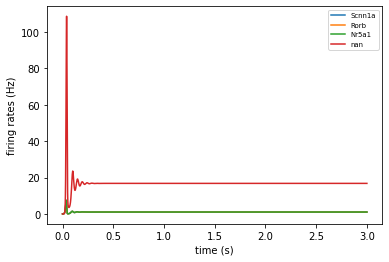

In [18]:
from bmtk.analyzer.firing_rates import plot_rates_popnet

plot_rates_popnet(
    cell_models_file='network_popnet/l4_node_types.csv', 
    rates_file='output_popnet/spike_rates.csv', 
    model_keys='model_name'
)